# WHAT IS TIME SERIES ANALYSIS

## DEFINITION:
Time series is a sequence of values(in our case, it is stock prices) of a variable, collected over a equally spaced time interval over a period of time. We are using time series forecasting methods which involves methods of analyzing our time series in order to extracting the meaningful insights from our time series and developing models so that we can predict the future values based on previously observed values.

## ABSTRACT:

Time series is a sequence of well-defined data points measured at a consistent time interval over a period. Basically, it is the use of statistical methods to analyses time series data and extract meaningful statistics and characteristics about the data. We will be using the S&P 500 dataset, which consists of data related to the stock prices of about 500 companies of the past 5 years. We will try to predict the prices of the various stocks, by using time series forecasting methods. By predicting the stock prices, we shall be diving into the world of stock price prediction and aim to help make investors make better decisions than before.Primarily we will try to predict Apple Stock data, and we excpect that the models can be used to evaluate other stocks as well.

As our research project, we plan on comparing multiple models with a single comparision criteria, and try to understand the best model to use for time series, and especially stock price prediction.
The algorithms we plan on using as of now are:
    1. AutoRegreession model
    2. Moving Average Model
    3. ARIMA
    4. Facebook Prophet
    5. RNN
    6. RNN with LSTM

## DATASET:

We will be using the S&P 500 dataset, which consists of data related to the stock prices of about 500 companies of the past 5 years. We will try to predict the prices of the various stocks, by using time series forecasting methods. By predicting the stock prices, we shall be diving into the world of stock price prediction and aim to help make investors make better decisions than before. Although we have the prices of 500 stocks, we will be using APPLE's stock data for prediction. It consists of Date, High Price, Low Price, Open Price and Close Price (for each day). The dates range from 2013 to 2018.
Since it is a timeseries, we have converted the Date into the index column. Also, we plan to only predict the Close price, since that is the price that actually matters.

Dataset link:-
https://www.kaggle.com/camnugent/sandp500/downloads/all_stocks_5yr.csv/4

In [1]:
# Importing the required libraries
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from statsmodels.tsa.stattools import adfuller

In [2]:
# Reading the dataset
apple = pd.read_csv('C:/Users/suraj/Project/individual_stocks_5yr/AAPL_data.csv', index_col='date', parse_dates=['date'])
apple.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [3]:
# Defining the function for mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# EDA
Here, we have used several graphs, to visualize the time series in different forms.
We have utilised the OHLC and Candlestick cahrt at first.

The we used the Moving Average Concept which basically takes the succession of averages derived from successive segments (typically of constant size and overlapping) of a series of values.
We used this to smooth out the time series and visualize it in a better way.

Finally, we have applied the Dickey Fuller Test. It tests the null hypothesis that a unit root is present in an autoregressive model. We get an estimated p-value, and that shows us the stationarity.

Also, we have used the Decompose method, to split the time series between Seasonlity and Trend. 

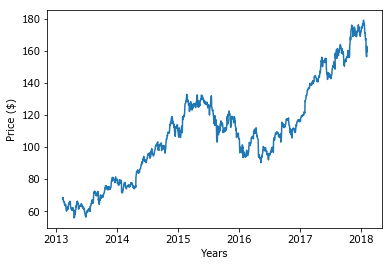

<Figure size 1224x576 with 0 Axes>

In [4]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(apple.index, apple['close'])
plt.xlabel('Years')
plt.ylabel('Price ($)');
plt.figure(figsize=(17, 8))
plt.show()

In [5]:
# Candlestick chart of 2008
trace = go.Candlestick(x=apple['2014'].index,
                open=apple['2014'].open,
                high=apple['2014'].high,
                low=apple['2014'].low,
                close=apple['2014'].close)
data = [trace]
iplot(data, filename='simple_candlestick')

## OHLC CHART:
OHLC is an acronym for Open High Low and Closing prices of a stock. OHLC chart is a bar chart representation of these values for each period. OHLC charts are useful since they show the four major data points over a period, with the closing price being considered the most important by many traders. These chart are useul since they help to understand the increasing or decreasing momentum. When the open and close are far apart it shows strong momentum, and when the open and close are close together it shows indecision or weak momentum (the speed at which the price of stocks in changing).

In [6]:
# OHLC chart of June 2008
trace = go.Ohlc(x=apple['06-2014'].index,
                open=apple['06-2014'].open,
                high=apple['06-2014'].high,
                low=apple['06-2014'].low,
                close=apple['06-2014'].close)
data = [trace]
iplot(data, filename='simple_ohlc')

In [7]:
# Defining the function for plotting the Moving Average
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")

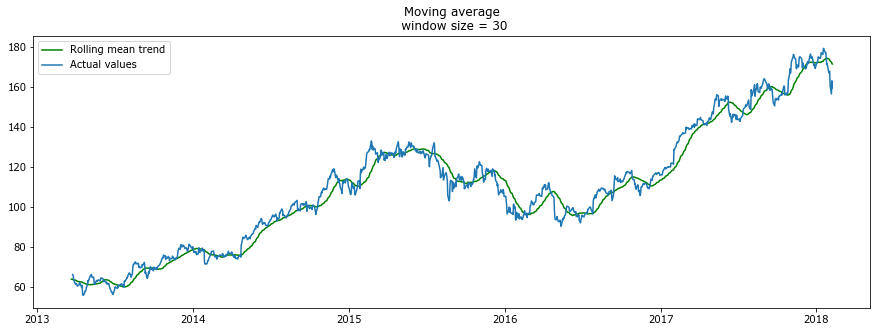

In [8]:
# Plotting the Moving Average for period of 30 days
plotMovingAverage(apple.close, 30) #30 days

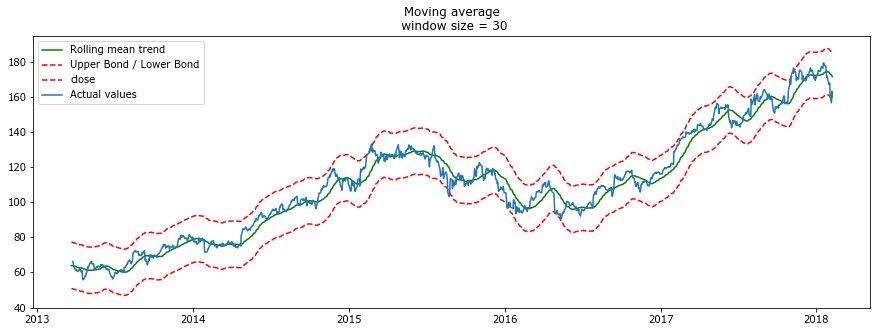

In [9]:
# Plotting the Moving Average for period of 30 days with upper and lower values
plotMovingAverage(apple.close,30 ,plot_intervals=True)

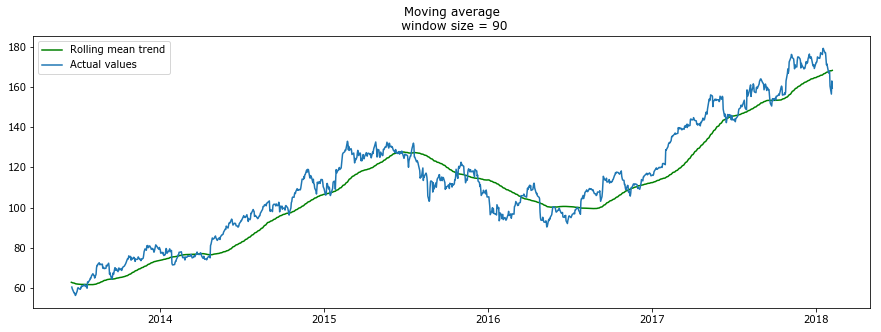

In [10]:
# Plotting the moving average for 90 days interval
plotMovingAverage(apple.close, 90) #90 days

In [11]:
# Exponential Smoothing assigns exponentially decreasing weights as the observation get older.
def exponential_smoothing(series, alpha):
    
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# Function to plot time series after applying exponential smoothing
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

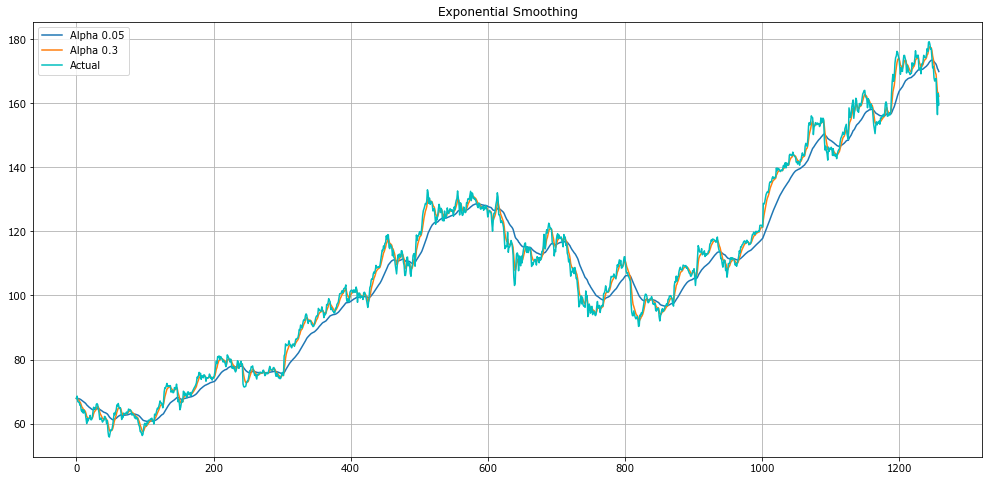

In [12]:
# Plotting the time series after exponential smoothing
plot_exponential_smoothing(apple.close, [0.05, 0.3])

In [13]:
# Single Smoothing does not excel in following the data when there is a trend. 
# This situation can be improved by the introduction of a second equation with a second constant
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

# Function to plot timeseries after applying double exponential smoothing
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

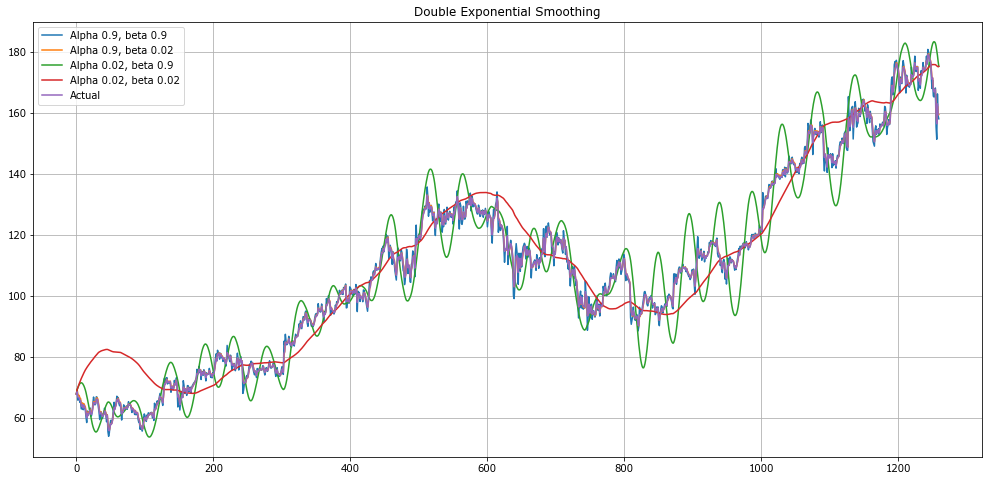

In [14]:
# Plotting time series after applying double exponential smoothing
plot_double_exponential_smoothing(apple.close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

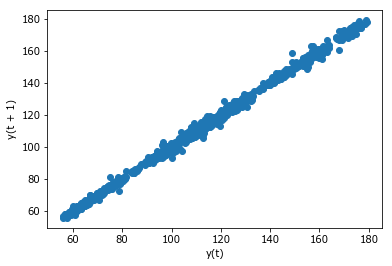

In [15]:
# A lag plot is a special type of scatter plot. Here we are plotting the time series value with its immediate 
# previous value
from pandas.plotting import lag_plot
lag_plot(apple.close)
plt.show()

# CHECKING STATIONARITY OF TIME SERIES:
A time series is said to be stationary if its statistical properties do not change with time. These properties, for example are mean, standard deviation, variation and autocorrelation. A non-stationary time series is a time series whose statistical properties vary over a period of time.

A non-stationary time series first needs to be converted to a stationary time series. This can be done by removing the trend and seasonality from the time series so that further statistical analysis can be done on a detrended time series data.

We are using Dickey–Fuller test to check if our time series is stationary or not.

## DICKEY–FULLER TEST:
The test is named after American statisticians David Dickey and Wayne Fuller who developed the test in 1979. It is used to determine whether a unit root, a feature that can cause issues in statistical inference, is present in an autoregressive model. 
We reject the null when the p-value is less than or equal to a specified significance level of 0.05 (5%),

In [16]:
# We are testing the stationarity of time series with the help of Dickey–Fuller test
# In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. 
# The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or 
# trend-stationarity.
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

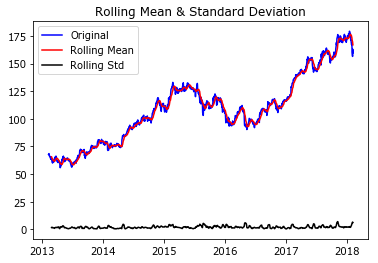

Results of Dickey-Fuller Test:
Test Statistic                   -0.665091
p-value                           0.855586
#Lags Used                        0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


In [17]:
# Testing our time series
test_stationarity(apple.close)

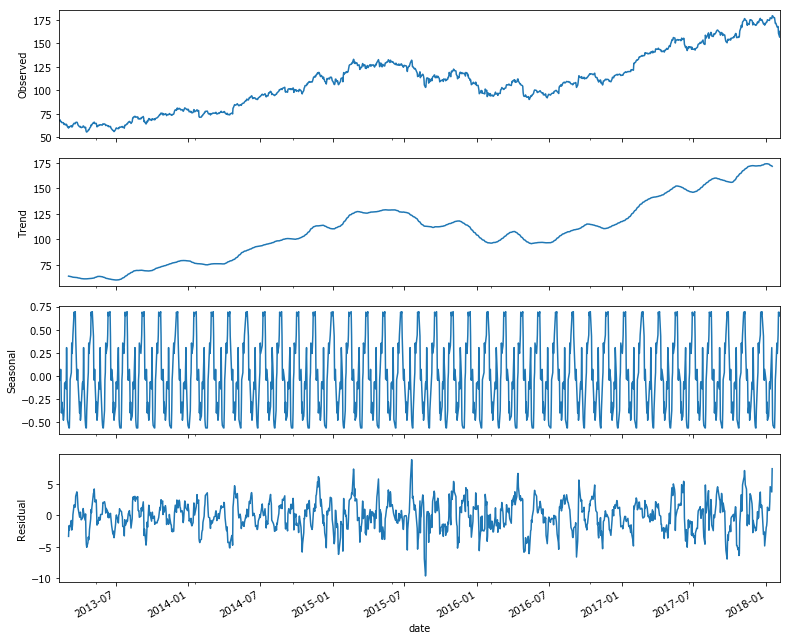

In [18]:
# Checking if our time series has seasionality and trend with a time interval of 30 days
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(apple.close, model='additive', freq=30)
fig = decomposition.plot()
plt.show()

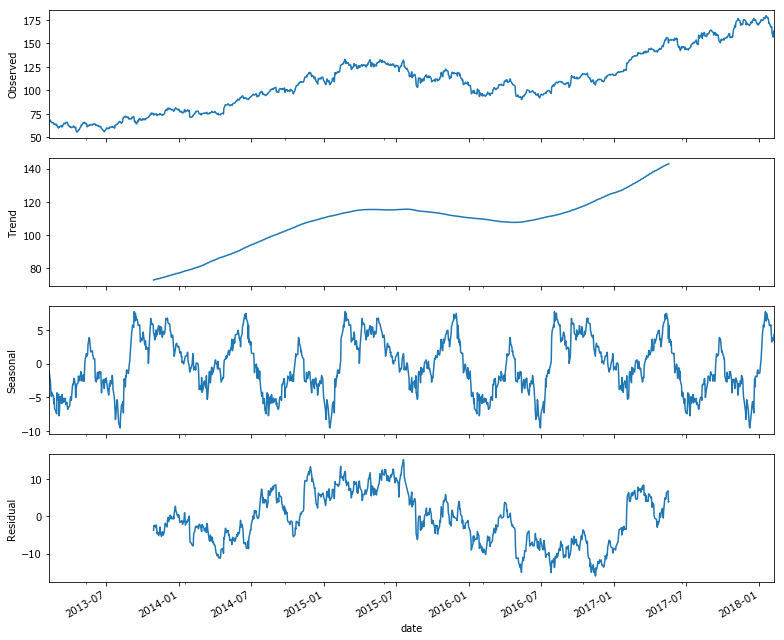

In [19]:
# Checking if our time series has seasionality and trend with a time interval of 365 days
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(apple.close, model='additive', freq=365)
fig = decomposition.plot()
plt.show()

# Performing Non-Stationarity

In order to apply the Moving Average model, Auto-regressive model and ARIMA model, we need the time series to be stationary. As you can see right now, the time series has an incremental growth, with variation. This shows that the time series is not stationary. 

To make it stationary, we can apply several methods. The first method we apply is:
    1. Log: Log basically works on the concept of penalizing the higher values more, that the lower value.
    2. Diff: We subtracted the time series from Day-1, to get a more stationary series.
As a result, we got a p value less than 0.05, which initially started with a p-value of 0.87.


We observe the time series, and find that it is stationary, and therby we can proceed further with it.

In the end, we observe the Partial and Full Autocorrelation.
In time series, the correlation is of the time series, is compared against the previous times.

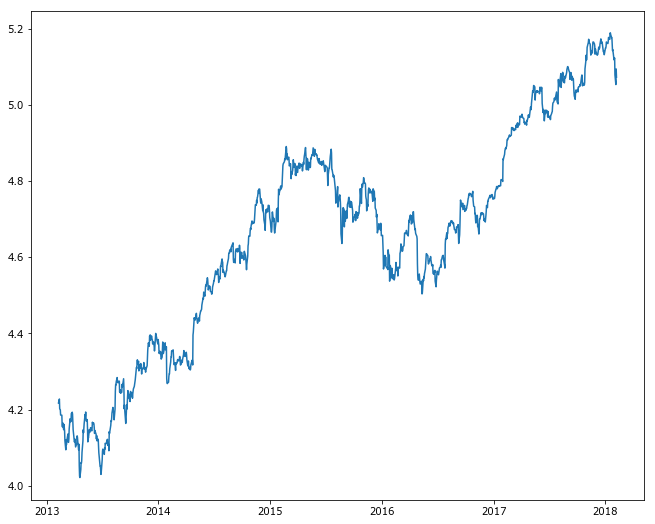

In [20]:
# Log works on the concept of penalizing the higher values more, that the lower value.
apple_close_log= np.log(apple.close)
plt.plot(apple_close_log)

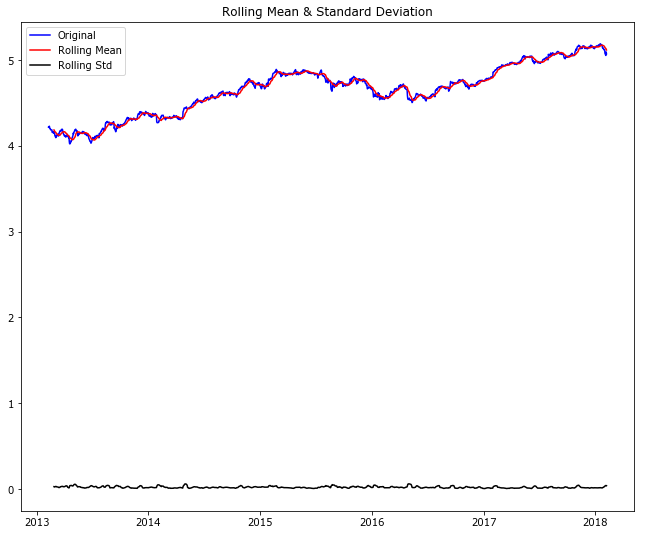

Results of Dickey-Fuller Test:
Test Statistic                   -0.930541
p-value                           0.777749
#Lags Used                        0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


In [21]:
# Testing our time series after appling log on time series
apple_close_log.dropna(inplace=True)
test_stationarity(apple_close_log)

As we can see that the p-value is 0.777749, our time series is not stationary. We will now take the log difference values
of the time series and see if it becomes stationary

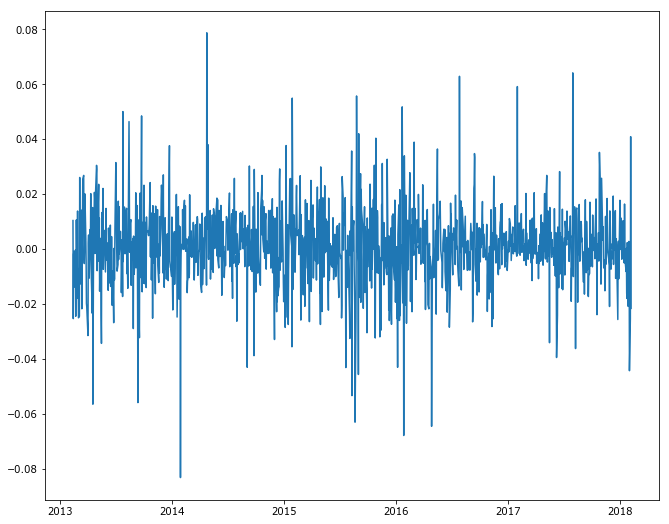

In [22]:
# Log difference of time series
apple_close_log_diff= apple_close_log-apple_close_log.shift()
plt.plot(apple_close_log_diff)

In [23]:
# Values after log difference
print(apple_close_log_diff)

date
2013-02-08         NaN
2013-02-11    0.010368
2013-02-12   -0.025386
2013-02-13   -0.001905
2013-02-14   -0.000900
2013-02-15   -0.013876
2013-02-19   -0.000370
2013-02-20   -0.024516
2013-02-21   -0.006236
2013-02-22    0.010593
2013-02-25   -0.017928
2013-02-26    0.013837
2013-02-27   -0.009849
2013-02-28   -0.007155
2013-03-01   -0.025073
2013-03-04   -0.024504
2013-03-05    0.026067
2013-03-06   -0.012796
2013-03-07    0.011493
2013-03-08    0.002638
2013-03-11    0.014145
2013-03-12   -0.021795
2013-03-13   -0.000186
2013-03-14    0.009642
2013-03-15    0.025475
2013-03-18    0.026821
2013-03-19   -0.002702
2013-03-20   -0.005317
2013-03-21    0.001436
2013-03-22    0.020075
                ...   
2017-12-26   -0.025697
2017-12-27    0.000176
2017-12-28    0.002810
2017-12-29   -0.010873
2018-01-02    0.017746
2018-01-03   -0.000174
2018-01-04    0.004634
2018-01-05    0.011321
2018-01-08   -0.003721
2018-01-09   -0.000115
2018-01-10   -0.000229
2018-01-11    0.005664
2018-0

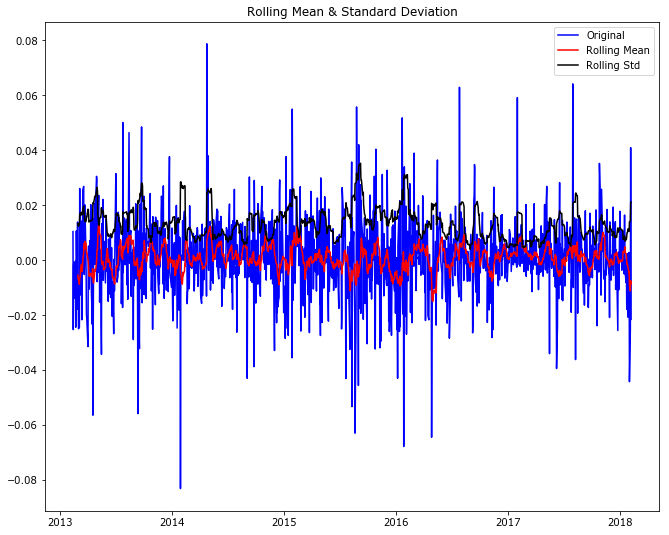

Results of Dickey-Fuller Test:
Test Statistic                  -34.347762
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1257.000000
Critical Value (1%)              -3.435563
Critical Value (5%)              -2.863842
Critical Value (10%)             -2.567996
dtype: float64


In [24]:
# Since there is no previous value than the first value in time series, the first value of log difference is NaN.
# We will drop this value here
apple_close_log_diff.dropna(inplace=True)
test_stationarity(apple_close_log_diff)

We can see that the p-value is 0 now. We can confirm that our time series is stationary now

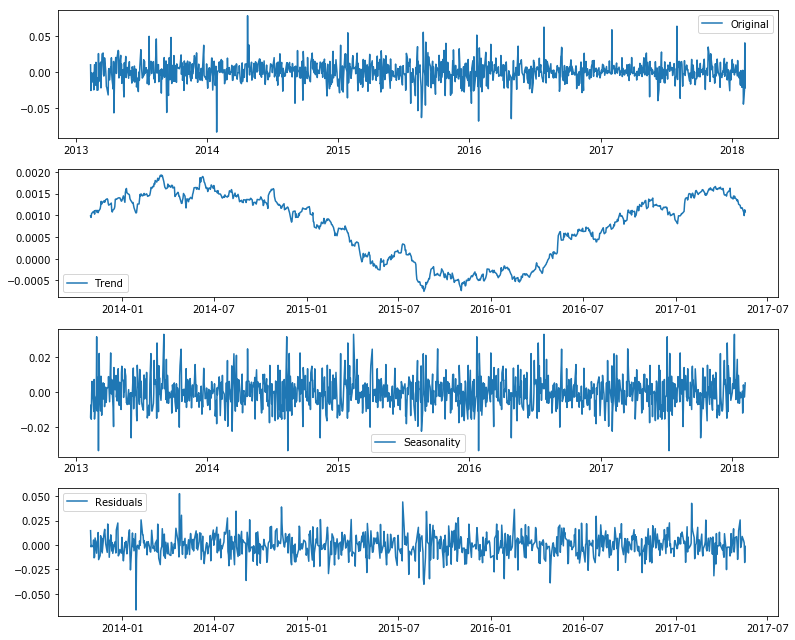

In [25]:
# We will try to decompose our time series to check trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(apple_close_log_diff, freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(apple_close_log_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [26]:
# Checking if NaN values are dropped
print(apple_close_log_diff)

date
2013-02-11    0.010368
2013-02-12   -0.025386
2013-02-13   -0.001905
2013-02-14   -0.000900
2013-02-15   -0.013876
2013-02-19   -0.000370
2013-02-20   -0.024516
2013-02-21   -0.006236
2013-02-22    0.010593
2013-02-25   -0.017928
2013-02-26    0.013837
2013-02-27   -0.009849
2013-02-28   -0.007155
2013-03-01   -0.025073
2013-03-04   -0.024504
2013-03-05    0.026067
2013-03-06   -0.012796
2013-03-07    0.011493
2013-03-08    0.002638
2013-03-11    0.014145
2013-03-12   -0.021795
2013-03-13   -0.000186
2013-03-14    0.009642
2013-03-15    0.025475
2013-03-18    0.026821
2013-03-19   -0.002702
2013-03-20   -0.005317
2013-03-21    0.001436
2013-03-22    0.020075
2013-03-25    0.003608
                ...   
2017-12-26   -0.025697
2017-12-27    0.000176
2017-12-28    0.002810
2017-12-29   -0.010873
2018-01-02    0.017746
2018-01-03   -0.000174
2018-01-04    0.004634
2018-01-05    0.011321
2018-01-08   -0.003721
2018-01-09   -0.000115
2018-01-10   -0.000229
2018-01-11    0.005664
2018-0

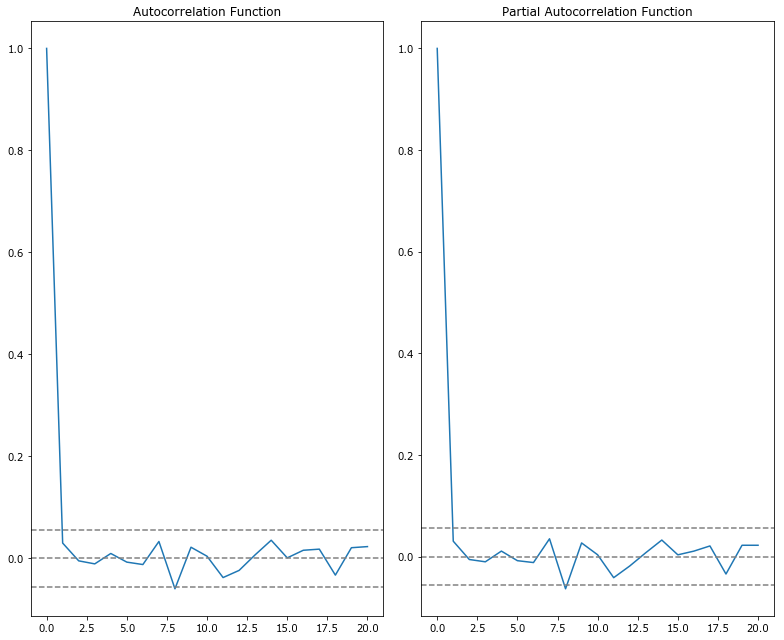

In [27]:
# ACF and PACF plots:
# ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values.
# It stands for auto-correlation function
# PACF is a partial auto-correlation function. it finds correlation of the residuals with the next lag value hence ‘partial’ 
# and not ‘complete’ as we remove already found variations before we find the next correlation.
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(apple_close_log_diff, nlags=20)
lag_pacf = pacf(apple_close_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(apple_close_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(apple_close_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(apple_close_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(apple_close_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# APPLYING MODELS:

Now that the time series is stationary, we can start applying the ARIMA models.

First we apply th Autoregressive Model. Autoregressive model is when a value from a time series is regressed on previous values from that same time series. It is the most basic model for Time series.

Then, we apply the moving average model, which is similar to Autoregressive, except that we take the error in the previous terms for our regression task.

Lastly, we apply the ARIMA model, which stands for Auto-Regression Integrated Moving Average model, which in a way is the combination of both the model.

All three models take in different parameters.AR model takes in p, MA model takes in q, and ARIMA takes in p,q and d.
We can estimate the values either using the auto-correlation graphs, or by using the auto-arima model.


p: the number of autoregressive terms

q: the number of nonseasonal differences

d: the number of moving-average terms

In all the models, to get appropriate predictions and a suitable comparision, we have to bring the originally altered values (for making time series stationary)  to the original values. We will use cumsum and exp for that.

# AR MODEL
In the field of statistics, AR Model which is an acronym for Autoregressive model is a representation of a type of random process which specifies that the output variable depends linearly on its own previous values.

In [138]:
# AR MODEL
# Importing the necessary libraries for ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

In [139]:
# Defining our model and applying it
model = ARMA(apple_close_log_diff, order=(3,0))
result = model.fit(disp=-1)
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1258
Model:                     ARMA(3, 0)   Log Likelihood                3534.269
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 23 Apr 2019   AIC                          -7058.537
Time:                        20:31:53   BIC                          -7032.851
Sample:                             0   HQIC                         -7048.884
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0007      0.000      1.630      0.103      -0.000       0.001
ar.L1.close     0.0302      0.028      1.072      0.284      -0.025       0.086
ar.L2.close    -0.0055      0.028     -0.193    

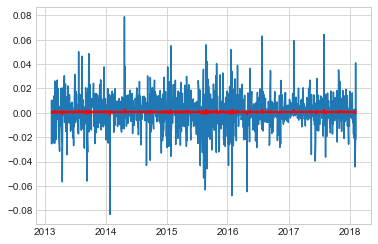

In [140]:
# Plot after applying for original and predicted values
plt.plot(apple_close_log_diff)
plt.plot(result.fittedvalues, color='red')

In [141]:
# Sample predicted values
predictions_ARIMA_diff1 = pd.Series(result.fittedvalues, copy=True)
print (predictions_ARIMA_diff1.head())

date
2013-02-11    0.000680
2013-02-12    0.000971
2013-02-13   -0.000166
2013-02-14    0.000643
2013-02-15    0.000917
dtype: float64


In [142]:
# Cumilitive sum of predicted values
predictions_ARIMA_diff_cumsum1= predictions_ARIMA_diff1.cumsum()
print (predictions_ARIMA_diff_cumsum1.head())

date
2013-02-11    0.000680
2013-02-12    0.001651
2013-02-13    0.001484
2013-02-14    0.002128
2013-02-15    0.003045
dtype: float64


In [143]:
# Adding the cumilitive sum to the log values
predictions_ARIMA_log1 = pd.Series(apple_close_log.ix[0], index=apple_close_log.index)
predictions_ARIMA_log1 = predictions_ARIMA_log1.add(predictions_ARIMA_diff_cumsum1,fill_value=0)
predictions_ARIMA_log1.head()

date
2013-02-08    4.217361
2013-02-11    4.218041
2013-02-12    4.219012
2013-02-13    4.218846
2013-02-14    4.219489
dtype: float64

Text(0.5, 1.0, 'RMSE: 14.3217')

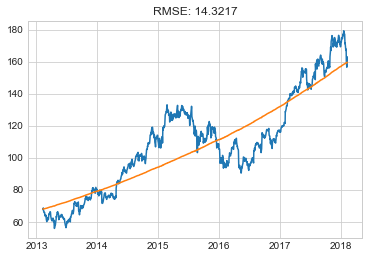

In [144]:
# Plotting the graph after appling exponent on the log predicted values
predictions_AR = np.exp(predictions_ARIMA_log1)
plt.plot(apple.close)
plt.plot(predictions_AR)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_AR-apple.close)**2)/len(apple.close)))

The AR model predicted values show similar variation as actual values but are not much nearer.

# MA MODEL
In time series analysis Moving Average model or a moving average process is used to model a univariate time series which specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

In [145]:
#MA Model
model = ARMA(apple_close_log_diff, order=(0,3))
result1 = model.fit()
print(result1.summary())
print("μ={} ,θ={}".format(result1.params[0],result1.params[1]))

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1258
Model:                     ARMA(0, 3)   Log Likelihood                3534.281
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 23 Apr 2019   AIC                          -7058.561
Time:                        20:34:24   BIC                          -7032.875
Sample:                             0   HQIC                         -7048.908
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0007      0.000      1.630      0.103      -0.000       0.001
ma.L1.close     0.0305      0.028      1.081      0.280      -0.025       0.086
ma.L2.close    -0.0046      0.028     -0.164    

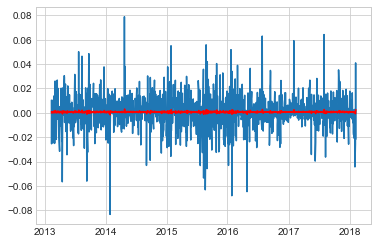

In [146]:
# Plotting the log difference values of time series with the predicted log value of the MA model
plt.plot(apple_close_log_diff)
plt.plot(result1.fittedvalues, color='red')

In [148]:
# Sample log predicted values
predictions_ARIMA_diff1 = pd.Series(result1.fittedvalues, copy=True)
print (predictions_ARIMA_diff1.head())

date
2013-02-11    0.000680
2013-02-12    0.000974
2013-02-13   -0.000174
2013-02-14    0.000633
2013-02-15    0.000951
dtype: float64


In [149]:
# Cumilitive sum of the log difference predicted values
predictions_MA_diff_cumsum1= predictions_ARIMA_diff1.cumsum()
print (predictions_MA_diff_cumsum1.head())

date
2013-02-11    0.000680
2013-02-12    0.001653
2013-02-13    0.001479
2013-02-14    0.002113
2013-02-15    0.003064
dtype: float64


In [150]:
# Adding the cumilitive sum to the log values
predictions_MA_log1 = pd.Series(apple_close_log.ix[0], index=apple_close_log.index)
predictions_MA_log1 = predictions_MA_log1.add(predictions_MA_diff_cumsum1,fill_value=0)
predictions_MA_log1.head()

date
2013-02-08    4.217361
2013-02-11    4.218041
2013-02-12    4.219015
2013-02-13    4.218841
2013-02-14    4.219474
dtype: float64

Text(0.5, 1.0, 'RMSE: 14.3275')

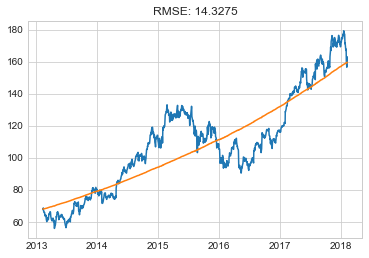

In [151]:
# Plotting the graph after appling exponent on the log predicted values
predictions_MA = np.exp(predictions_MA_log1)
plt.plot(apple.close)
plt.plot(predictions_MA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_MA-apple.close)**2)/len(apple.close)))

The predicted values show similar trend with actual values, but are again not much nearer to actual values.

# ARIMA Model
It stands for AutoRegressive Integrated Moving Average. It is combined model which takes both Auto-Regression model and Moving Average model consideration. It is a class of statistical models for analyzing and forecasting time series data. It provides a simple yet powerful method for making skillful time series forecasts. It involves the below key aspects:
<br> <br>
AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
<br>
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
<br>
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

These values are passed explicity as a model parameter, which is represented as ARIMA(p,q,d). These are specified as:
<br>
p: The number of lag observations included in the model, also called the lag order.
<br>
d: The number of times that the raw observations are differenced, also called the degree of differencing.
<br>
q: The size of the moving average window, also called the order of moving average.

Text(0.5, 1.0, 'RSS: 0.2671')

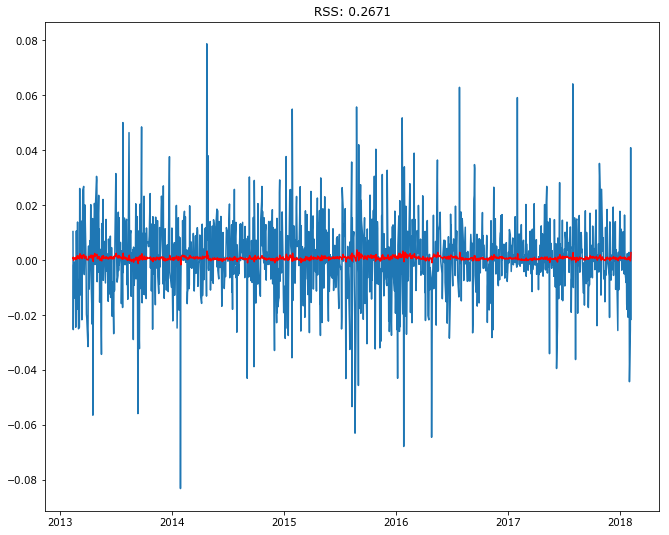

In [38]:
#ARIMA
model = ARIMA(apple_close_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(apple_close_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-apple_close_log_diff)**2))

In [39]:
# Sample result of logged values
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

date
2013-02-11    0.000706
2013-02-12    0.000997
2013-02-13   -0.000143
2013-02-14    0.000709
2013-02-15    0.000784
dtype: float64


In [40]:
# Cumilitive sum of log differences
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

date
2013-02-11    0.000706
2013-02-12    0.001703
2013-02-13    0.001559
2013-02-14    0.002269
2013-02-15    0.003053
dtype: float64


In [41]:
# Adding the cumilitive sum to the log differences
predictions_ARIMA_log = pd.Series(apple_close_log.ix[0], index=apple_close_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2013-02-08    4.217361
2013-02-11    4.218067
2013-02-12    4.219064
2013-02-13    4.218921
2013-02-14    4.219630
dtype: float64

Text(0.5, 1.0, 'RMSE: 16.7829')

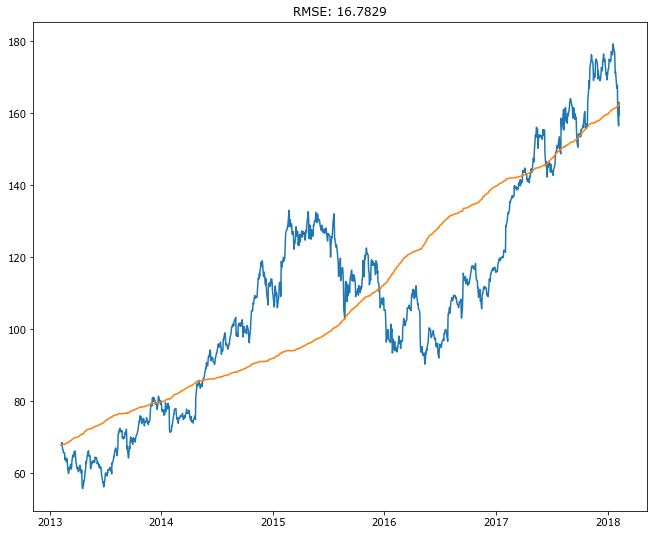

In [44]:
# Plotting the graph for actual and predicted values
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(apple.close)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-apple.close)**2)/len(apple.close)))

The graph is showing some non-linearity now and has quite a similar trend as the actual values, but is not much closer, altough better than MA and AR values

In [47]:
# Preparing the data to show Original and Predicted values
df_dict = {'Original':apple.close, 'Predicted':predictions_ARIMA}

In [48]:
dframe = pd.DataFrame(df_dict)
dframe

,Original,Predicted
date,,
2013-02-08,67.8542,67.854200
2013-02-11,68.5614,67.902101
2013-02-12,66.8428,67.969828
2013-02-13,66.7156,67.960100
2013-02-14,66.6556,68.008328
2013-02-15,65.7371,68.061656
2013-02-19,65.7128,68.088983
2013-02-20,64.1214,68.149765
2013-02-21,63.7228,68.162170


# Facebook Prophet

Prophet is open source software released by Facebook’s Core Data Science team. 
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

This library is very intuitive, and performs tuning of the  time series by itself. 
We took the 'Date' and the 'Close' price, converted them into 'y' and 'ds', and performed the FB prophet with it.

In [152]:
# Import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from fbprophet import Prophet
# Statsmodels widely known for forecasting than Prophet
import statsmodels.api as sm
from scipy import stats
#from pandas.core import datetools
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

# plt.style.available
plt.style.use("seaborn-whitegrid")

In [197]:
# Loading the time series dataset
apple_df = pd.read_csv(r'C:/Users/suraj/Project/individual_stocks_5yr/AAPL_data.csv')
apple_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [198]:
# Converting the timeseries in the facebook prophet acceptable format
df=apple_df.rename(columns={'date':'ds', 'close':'y'})

In [199]:
# Removing the unnecessary columns
df = df.drop(['open', 'high', 'low','volume', 'Name'], axis=1)

In [200]:
# Sample dataset to after converting to prophet acceptable format
df.head()

,ds,y
0,2013-02-08,67.8542
1,2013-02-11,68.5614
2,2013-02-12,66.8428
3,2013-02-13,66.7156
4,2013-02-14,66.6556


In [201]:
# Logging the stock price
df['y'] = np.log(df['y'])

In [202]:
df.tail()

,ds,y
1254,2018-02-01,5.122654
1255,2018-02-02,5.078294
1256,2018-02-05,5.052992
1257,2018-02-06,5.093934
1258,2018-02-07,5.072295


In [203]:
# Appling prophet on time series
model = Prophet()
model.fit(df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [204]:
# Predicting the 90 days
future = model.make_future_dataframe(periods=90)
future.tail()

,ds
1344,2018-05-04
1345,2018-05-05
1346,2018-05-06
1347,2018-05-07
1348,2018-05-08


In [205]:
# Predicting the 90 days
forecast = model.predict(future)

In [206]:
# Sample forecast values
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1344,2018-05-04,5.269248,5.187249,5.380592,5.178173,5.367566,0.014502,0.014502,0.014502,-0.005319,-0.005319,-0.005319,0.019821,0.019821,0.019821,0.0,0.0,0.0,5.283750
1345,2018-05-05,5.270070,5.198554,5.410907,5.177099,5.371505,0.031676,0.031676,0.031676,0.011342,0.011342,0.011342,0.020334,0.020334,0.020334,0.0,0.0,0.0,5.301747
1346,2018-05-06,5.270893,5.205164,5.405340,5.176351,5.374919,0.032136,0.032136,0.032136,0.011342,0.011342,0.011342,0.020794,0.020794,0.020794,0.0,0.0,0.0,5.303029
1347,2018-05-07,5.271715,5.182606,5.407481,5.175494,5.377395,0.016964,0.016964,0.016964,-0.004245,-0.004245,-0.004245,0.021209,0.021209,0.021209,0.0,0.0,0.0,5.288679
1348,2018-05-08,5.272538,5.183367,5.402224,5.173589,5.380235,0.017733,0.017733,0.017733,-0.003859,-0.003859,-0.003859,0.021592,0.021592,0.021592,0.0,0.0,0.0,5.290271


In [207]:
# forecasted values with upper and lower boundaries for predicted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1344,2018-05-04,5.283750,5.187249,5.380592
1345,2018-05-05,5.301747,5.198554,5.410907
1346,2018-05-06,5.303029,5.205164,5.405340
1347,2018-05-07,5.288679,5.182606,5.407481
1348,2018-05-08,5.290271,5.183367,5.402224


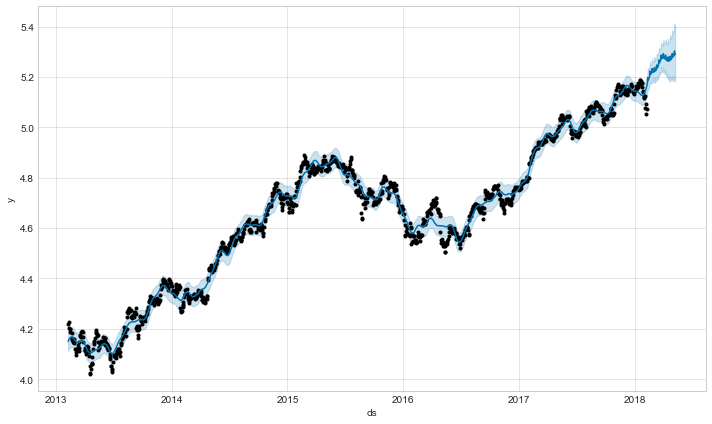

In [208]:
# Plot after prediction
model.plot(forecast);

In [209]:
# Preparing forecast for 2 years
two_years = forecast.set_index('ds').join(apple_df)

In [210]:
two_years

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,...,multiplicative_terms_lower,multiplicative_terms_upper,yhat,date,open,high,low,close,volume,Name
ds,,,,,,,,,,,,,,,,,,,,,
2013-02-08,4.181816,4.110744,4.187964,4.181816,4.181816,-0.031242,-0.031242,-0.031242,-0.005319,-0.005319,...,0.0,0.0,4.150574,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,4.177569,4.121609,4.196971,4.177569,4.177569,-0.018806,-0.018806,-0.018806,-0.004245,-0.004245,...,0.0,0.0,4.158763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-12,4.176153,4.124042,4.199492,4.176153,4.176153,-0.014862,-0.014862,-0.014862,-0.003859,-0.003859,...,0.0,0.0,4.161291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-13,4.174737,4.127374,4.199267,4.174737,4.174737,-0.011985,-0.011985,-0.011985,-0.004341,-0.004341,...,0.0,0.0,4.162751,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-14,4.173321,4.128524,4.203260,4.173321,4.173321,-0.009447,-0.009447,-0.009447,-0.004920,-0.004920,...,0.0,0.0,4.163874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-15,4.171905,4.124717,4.199565,4.171905,4.171905,-0.007006,-0.007006,-0.007006,-0.005319,-0.005319,...,0.0,0.0,4.164899,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-19,4.166241,4.128249,4.204375,4.166241,4.166241,0.002595,0.002595,0.002595,-0.003859,-0.003859,...,0.0,0.0,4.168836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-20,4.164825,4.127785,4.206029,4.164825,4.164825,0.003308,0.003308,0.003308,-0.004341,-0.004341,...,0.0,0.0,4.168133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-21,4.163409,4.130831,4.207309,4.163409,4.163409,0.003603,0.003603,0.003603,-0.004920,-0.004920,...,0.0,0.0,4.167012,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
# Augmenting values to be predicted
two_years = two_years[['close', 'yhat', 'yhat_upper', 'yhat_lower' ]].tail(800)
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)

In [214]:
# Sample data to be predicted
df_all_cols = pd.concat([apple_df.date, forecast.yhat, apple_df.close], axis = 1)
df_all_cols

,date,yhat,close
0,2013-02-08,4.150574,67.8542
1,2013-02-11,4.158763,68.5614
2,2013-02-12,4.161291,66.8428
3,2013-02-13,4.162751,66.7156
4,2013-02-14,4.163874,66.6556
5,2013-02-15,4.164899,65.7371
6,2013-02-19,4.168836,65.7128
7,2013-02-20,4.168133,64.1214
8,2013-02-21,4.167012,63.7228
9,2013-02-22,4.165772,64.4014


In [191]:
# Applying exponent to remove the log
df_all_cols['yhat']=np.exp(df_all_cols.yhat)

In [192]:
# Replacing the index of augmented data with date
df_all_cols = df_all_cols.set_index('date')

In [193]:
# Dropping NaN values
df_all_cols1=df_all_cols.dropna()

In [194]:
# Predicted values for 2 years
df_all_cols1

,yhat,close
date,,
2013-02-08,63.470446,67.8542
2013-02-11,63.992288,68.5614
2013-02-12,64.154265,66.8428
2013-02-13,64.248050,66.7156
2013-02-14,64.320208,66.6556
2013-02-15,64.386179,65.7371
2013-02-19,64.640186,65.7128
2013-02-20,64.594721,64.1214
2013-02-21,64.522350,63.7228


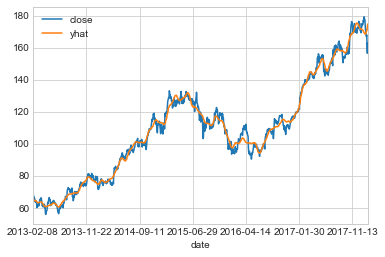

In [195]:
# Plotting the predicted values
df_all_cols1[['close', 'yhat']].plot()

In [196]:
print ("RMSE Value using Prophet is", np.sqrt(sum((df_all_cols1.yhat-df_all_cols1.close)**2)/len(df_all_cols1.close)))

RMSE Value using Prophet is 3.232001010495516


Prophet has a very low RMSE value and it shows that the predicted values are very closer to the actual values

# LSTM

LSTM is a type of Artificial Neural Network architecture in the field of deep learning. It has a feedback connections which make it a general purpose computer, which means that it can be used anywhere and makes it a very powerful model since it can not only process single data points , but also entire sequences of data.

LSTM unit has a cell, an input gate, an output gate and a forget gate. Cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. LSTM suits well for classification, processing and making predictions for time series data analysis since there can be lags of unknown duration between important events in a time series. It overcomes the exploding and vanishing gradient problems that are encountered while training RNN.

In [76]:
# Importing the necessary libraries for LSTM
import numpy as np                   # linear algebra
import pandas as pd                  # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [77]:
# Loading the time series
data = pd.read_csv(r'C:/Users/suraj/Project/individual_stocks_5yr/AAPL_data.csv')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [78]:
#We will be using the closing data of AAPL
cl = data[data['Name']=='AAPL'].close
scl = MinMaxScaler()
#Scale the data
cl = cl.values.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)
cl

array([[0.0977103 ],
       [0.103438  ],
       [0.08951884],
       ...,
       [0.81558288],
       [0.86855117],
       [0.84028522]])

In [79]:
# Splitting the data in train test
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
X,y = processData(cl,7)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1000
251
1000
251


In [80]:
# Defining our model
model = Sequential()
model.add(LSTM(256,input_shape=(7,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Train on 1000 samples, validate on 251 samples
Epoch 1/300
1000/1000 [==============================] - ETA: 20s - loss: 0.00 - ETA: 3s - loss: 0.0011 - ETA: 1s - loss: 9.4537e-0 - ETA: 0s - loss: 0.0018    - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - 1s 1ms/step - loss: 0.0015 - val_loss: 8.3715e-04
Epoch 2/300
1000/1000 [==============================] - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - 0s 345us/step - loss: 0.0042 - val_loss: 6.4288e-04
Epoch 3/300
1000/1000 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 8.8504e-0 - ETA: 0s - loss: 8.8891e-0 - ETA: 0s - loss: 9.5131e-0 - ETA: 0s - loss: 9.9742e-0 - ETA: 0s - loss: 9.7795e-0 - 0s 329us/step - loss: 9.2577e-04 - val_loss: 7.0132e-04
Epoch 4/300
1000/1000 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - 

Epoch 59/300
1000/1000 [==============================] - ETA: 0s - loss: 1.0320e-0 - ETA: 0s - loss: 1.1044e-0 - ETA: 0s - loss: 1.3925e-0 - ETA: 0s - loss: 1.9377e-0 - ETA: 0s - loss: 2.4351e-0 - ETA: 0s - loss: 2.4608e-0 - 0s 324us/step - loss: 2.4356e-04 - val_loss: 0.0040
Epoch 60/300
1000/1000 [==============================] - ETA: 0s - loss: 1.0264e-0 - ETA: 0s - loss: 1.0924e-0 - ETA: 0s - loss: 1.2374e-0 - ETA: 0s - loss: 1.8833e-0 - ETA: 0s - loss: 2.3681e-0 - ETA: 0s - loss: 2.4015e-0 - 0s 359us/step - loss: 2.4084e-04 - val_loss: 0.0040
Epoch 61/300
1000/1000 [==============================] - ETA: 0s - loss: 1.0249e-0 - ETA: 0s - loss: 1.0828e-0 - ETA: 0s - loss: 1.2151e-0 - ETA: 0s - loss: 1.7868e-0 - ETA: 0s - loss: 2.2840e-0 - ETA: 0s - loss: 2.3914e-0 - 0s 358us/step - loss: 2.3833e-04 - val_loss: 0.0040
Epoch 62/300
1000/1000 [==============================] - ETA: 0s - loss: 1.0270e-0 - ETA: 0s - loss: 1.0687e-0 - ETA: 0s - loss: 1.1957e-0 - ETA: 0s - loss: 1.8523e-

Epoch 117/300
1000/1000 [==============================] - ETA: 0s - loss: 8.5210e-0 - ETA: 0s - loss: 8.1254e-0 - ETA: 0s - loss: 8.5441e-0 - ETA: 0s - loss: 1.2869e-0 - ETA: 0s - loss: 1.6770e-0 - ETA: 0s - loss: 1.7397e-0 - 0s 341us/step - loss: 1.7076e-04 - val_loss: 0.0023
Epoch 118/300
1000/1000 [==============================] - ETA: 0s - loss: 8.2540e-0 - ETA: 0s - loss: 8.1079e-0 - ETA: 0s - loss: 9.4736e-0 - ETA: 0s - loss: 1.3834e-0 - ETA: 0s - loss: 1.7446e-0 - ETA: 0s - loss: 1.6756e-0 - 0s 312us/step - loss: 1.6998e-04 - val_loss: 0.0023
Epoch 119/300
1000/1000 [==============================] - ETA: 0s - loss: 7.8481e-0 - ETA: 0s - loss: 7.9206e-0 - ETA: 0s - loss: 9.3406e-0 - ETA: 0s - loss: 1.3643e-0 - ETA: 0s - loss: 1.7302e-0 - ETA: 0s - loss: 1.6640e-0 - 0s 318us/step - loss: 1.6888e-04 - val_loss: 0.0023
Epoch 120/300
1000/1000 [==============================] - ETA: 0s - loss: 7.5697e-0 - ETA: 0s - loss: 7.7768e-0 - ETA: 0s - loss: 9.2486e-0 - ETA: 0s - loss: 1.35

1000/1000 [==============================] - ETA: 0s - loss: 7.5899e-0 - ETA: 0s - loss: 7.6715e-0 - ETA: 0s - loss: 8.2361e-0 - ETA: 0s - loss: 1.3284e-0 - ETA: 0s - loss: 1.7520e-0 - ETA: 0s - loss: 1.6874e-0 - 0s 324us/step - loss: 1.6737e-04 - val_loss: 0.0028
Epoch 176/300
1000/1000 [==============================] - ETA: 0s - loss: 7.5774e-0 - ETA: 0s - loss: 7.8745e-0 - ETA: 0s - loss: 9.3399e-0 - ETA: 0s - loss: 1.3427e-0 - ETA: 0s - loss: 1.7255e-0 - ETA: 0s - loss: 1.6481e-0 - 0s 324us/step - loss: 1.6747e-04 - val_loss: 0.0028
Epoch 177/300
1000/1000 [==============================] - ETA: 0s - loss: 7.5893e-0 - ETA: 0s - loss: 7.8871e-0 - ETA: 0s - loss: 9.3554e-0 - ETA: 0s - loss: 1.3441e-0 - ETA: 0s - loss: 1.7547e-0 - ETA: 0s - loss: 1.6920e-0 - 0s 331us/step - loss: 1.6763e-04 - val_loss: 0.0029
Epoch 178/300
1000/1000 [==============================] - ETA: 0s - loss: 7.5922e-0 - ETA: 0s - loss: 7.8919e-0 - ETA: 0s - loss: 8.2600e-0 - ETA: 0s - loss: 1.2496e-0 - ETA: 0

Epoch 204/300
1000/1000 [==============================] - ETA: 0s - loss: 6.4277e-0 - ETA: 0s - loss: 7.2806e-0 - ETA: 0s - loss: 7.7826e-0 - ETA: 0s - loss: 1.1690e-0 - ETA: 0s - loss: 1.5681e-0 - ETA: 0s - loss: 1.6312e-0 - 0s 343us/step - loss: 1.5972e-04 - val_loss: 0.0029
Epoch 205/300
1000/1000 [==============================] - ETA: 0s - loss: 1.2677e-0 - ETA: 0s - loss: 1.0022e-0 - ETA: 0s - loss: 1.0125e-0 - ETA: 0s - loss: 1.4364e-0 - ETA: 0s - loss: 1.7910e-0 - ETA: 0s - loss: 1.9118e-0 - ETA: 0s - loss: 1.7929e-0 - 0s 359us/step - loss: 1.8145e-04 - val_loss: 0.0027
Epoch 206/300
1000/1000 [==============================] - ETA: 0s - loss: 1.1266e-0 - ETA: 0s - loss: 1.0752e-0 - ETA: 0s - loss: 1.0200e-0 - ETA: 0s - loss: 1.4448e-0 - ETA: 0s - loss: 1.8750e-0 - ETA: 0s - loss: 1.8303e-0 - 0s 343us/step - loss: 1.7801e-04 - val_loss: 0.0025
Epoch 207/300
1000/1000 [==============================] - ETA: 0s - loss: 2.6870e-0 - ETA: 0s - loss: 1.6130e-0 - ETA: 0s - loss: 1.65

Epoch 262/300
1000/1000 [==============================] - ETA: 0s - loss: 7.3171e-0 - ETA: 0s - loss: 8.3837e-0 - ETA: 0s - loss: 9.8844e-0 - ETA: 0s - loss: 1.4129e-0 - ETA: 0s - loss: 1.8168e-0 - ETA: 0s - loss: 1.7948e-0 - 0s 331us/step - loss: 1.7746e-04 - val_loss: 0.0051
Epoch 263/300
1000/1000 [==============================] - ETA: 0s - loss: 9.2819e-0 - ETA: 0s - loss: 1.2703e-0 - ETA: 0s - loss: 1.2847e-0 - ETA: 0s - loss: 1.8440e-0 - ETA: 0s - loss: 2.3579e-0 - ETA: 0s - loss: 2.2082e-0 - 0s 329us/step - loss: 2.1826e-04 - val_loss: 0.0043
Epoch 264/300
1000/1000 [==============================] - ETA: 0s - loss: 5.1098e-0 - ETA: 0s - loss: 2.6707e-0 - ETA: 0s - loss: 2.1964e-0 - ETA: 0s - loss: 2.8746e-0 - ETA: 0s - loss: 3.3318e-0 - ETA: 0s - loss: 2.9910e-0 - 0s 325us/step - loss: 2.9202e-04 - val_loss: 0.0066
Epoch 265/300
1000/1000 [==============================] - ETA: 0s - loss: 6.6844e-0 - ETA: 0s - loss: 8.4630e-0 - ETA: 0s - loss: 8.8734e-0 - ETA: 0s - loss: 1.24

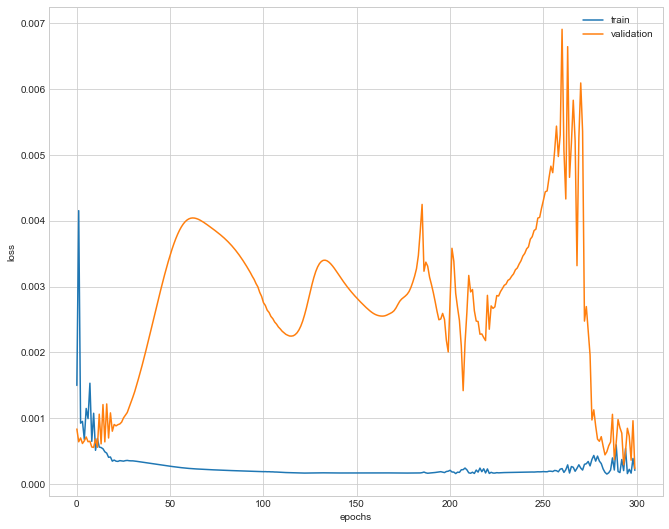

In [81]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])

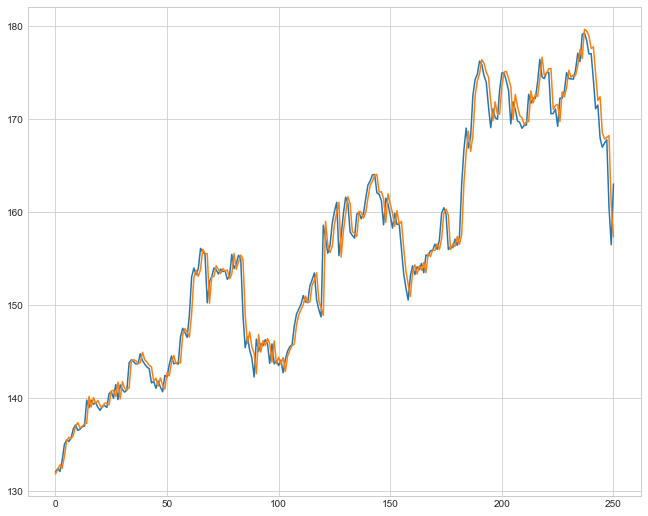

In [82]:
#We see this is pretty jumpy but we will keep it at 300 epochs. With more data, it should smooth out the loss
#Lets look at the fit
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

#This looks good for finding a trend

In [86]:
# Displaying the predicted and actual values
act = []
pred = []
for i in range(251):
    Xt = model.predict(X_test[i].reshape(1,7,1))
    print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
    pred.append(scl.inverse_transform(Xt).reshape(-1,1))
    act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))
pred = scl.inverse_transform(y_test.reshape(-1,1))
actual = scl.inverse_transform(Xt)

predicted:[[131.83241]], actual:[[132.04]]
predicted:[[132.35902]], actual:[[132.42]]
predicted:[[132.80879]], actual:[[132.12]]
predicted:[[132.46349]], actual:[[133.29]]
predicted:[[133.72275]], actual:[[135.02]]
predicted:[[135.3917]], actual:[[135.51]]
predicted:[[135.79636]], actual:[[135.345]]
predicted:[[135.62234]], actual:[[135.72]]
predicted:[[136.00601]], actual:[[136.7]]
predicted:[[136.97807]], actual:[[137.11]]
predicted:[[137.36314]], actual:[[136.53]]
predicted:[[136.78929]], actual:[[136.66]]
predicted:[[136.97792]], actual:[[136.93]]
predicted:[[137.21988]], actual:[[136.99]]
predicted:[[137.29675]], actual:[[139.79]]
predicted:[[140.1661]], actual:[[138.96]]
predicted:[[139.03773]], actual:[[139.78]]
predicted:[[140.06538]], actual:[[139.34]]
predicted:[[139.44133]], actual:[[139.52]]
predicted:[[139.75313]], actual:[[139.]]
predicted:[[139.2004]], actual:[[138.68]]
predicted:[[138.97702]], actual:[[139.14]]
predicted:[[139.44733]], actual:[[139.2]]
predicted:[[139.4

In [87]:
print ("RMSE Value using LSTM is", np.sqrt(sum((pred-actual)**2)/len(act)))

RMSE Value using LSTM is [12.42646634]


The RMSE value in LSTM is not as good as prophet, but its predicted value show a much closer value. Its quite a good tecnique for time series analysis but took more time to train than prophet

# Stacked LSTM

The original LSTM comprises one LSTM hidden layer which is followed by a standard Feedforward output layer. 
Stacked LSTM has additional multiple hidden LSTM layers where each layer contains multiple memory cells. These multiple LSTM layers make the model deeper that is generally attributed to the success of the approach on a wide range of challenging prediction problems.

### Stacked LSTM architecture
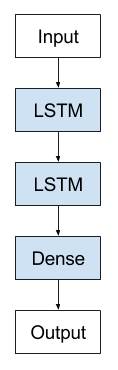


In [88]:
#Lets give a try with a stacked LSTM
#Build the model
model = Sequential()
model.add(LSTM(256,return_sequences=True,input_shape=(7,1)))
model.add(LSTM(256))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

Train on 1000 samples, validate on 251 samples
Epoch 1/300
1000/1000 [==============================] - ETA: 32s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 6s - loss: 0.0011 - ETA: 4s - loss: 8.4929e-0 - ETA: 3s - loss: 9.8588e-0 - ETA: 2s - loss: 0.0017    - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.001 - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.001 - 2s 2ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 2/300
1000/1000 [==============================] - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 1s 928us/ste

Epoch 35/300
1000/1000 [==============================] - ETA: 0s - loss: 1.5108e-0 - ETA: 0s - loss: 1.8706e-0 - ETA: 0s - loss: 1.6448e-0 - ETA: 0s - loss: 1.7530e-0 - ETA: 0s - loss: 2.0006e-0 - ETA: 0s - loss: 2.4855e-0 - ETA: 0s - loss: 2.5456e-0 - ETA: 0s - loss: 3.0099e-0 - ETA: 0s - loss: 2.9898e-0 - ETA: 0s - loss: 3.3805e-0 - ETA: 0s - loss: 3.4899e-0 - ETA: 0s - loss: 3.5041e-0 - ETA: 0s - loss: 3.5312e-0 - ETA: 0s - loss: 3.6219e-0 - 1s 865us/step - loss: 3.6507e-04 - val_loss: 0.0097
Epoch 36/300
1000/1000 [==============================] - ETA: 0s - loss: 1.3488e-0 - ETA: 0s - loss: 1.4956e-0 - ETA: 0s - loss: 1.6834e-0 - ETA: 0s - loss: 1.7130e-0 - ETA: 0s - loss: 1.6870e-0 - ETA: 0s - loss: 2.3363e-0 - ETA: 0s - loss: 2.4183e-0 - ETA: 0s - loss: 2.8661e-0 - ETA: 0s - loss: 3.1976e-0 - ETA: 0s - loss: 3.3650e-0 - ETA: 0s - loss: 3.3854e-0 - ETA: 0s - loss: 3.4113e-0 - ETA: 0s - loss: 3.5026e-0 - ETA: 0s - loss: 3.4658e-0 - 1s 848us/step - loss: 3.5310e-04 - val_loss: 0.0

Epoch 52/300
1000/1000 [==============================] - ETA: 0s - loss: 2.4034e-0 - ETA: 0s - loss: 2.2810e-0 - ETA: 0s - loss: 1.8114e-0 - ETA: 0s - loss: 1.8323e-0 - ETA: 0s - loss: 1.7554e-0 - ETA: 0s - loss: 1.7164e-0 - ETA: 0s - loss: 1.9683e-0 - ETA: 0s - loss: 2.4411e-0 - ETA: 0s - loss: 2.6452e-0 - ETA: 0s - loss: 2.9098e-0 - ETA: 0s - loss: 2.9560e-0 - ETA: 0s - loss: 2.9092e-0 - ETA: 0s - loss: 2.9026e-0 - 1s 855us/step - loss: 2.8489e-04 - val_loss: 0.0058
Epoch 53/300
1000/1000 [==============================] - ETA: 0s - loss: 2.8893e-0 - ETA: 0s - loss: 2.2453e-0 - ETA: 0s - loss: 2.0542e-0 - ETA: 0s - loss: 1.9718e-0 - ETA: 0s - loss: 1.9014e-0 - ETA: 0s - loss: 2.4879e-0 - ETA: 0s - loss: 2.6110e-0 - ETA: 0s - loss: 2.8347e-0 - ETA: 0s - loss: 3.0160e-0 - ETA: 0s - loss: 3.1294e-0 - ETA: 0s - loss: 3.0434e-0 - ETA: 0s - loss: 2.9873e-0 - 1s 826us/step - loss: 2.9493e-04 - val_loss: 0.0052
Epoch 54/300
1000/1000 [==============================] - ETA: 0s - loss: 3.7138

Epoch 69/300
1000/1000 [==============================] - ETA: 0s - loss: 1.6049e-0 - ETA: 0s - loss: 1.5127e-0 - ETA: 0s - loss: 1.6032e-0 - ETA: 0s - loss: 1.4269e-0 - ETA: 0s - loss: 1.3190e-0 - ETA: 0s - loss: 1.2031e-0 - ETA: 0s - loss: 1.2200e-0 - ETA: 0s - loss: 1.4499e-0 - ETA: 0s - loss: 1.4961e-0 - ETA: 0s - loss: 1.6944e-0 - ETA: 0s - loss: 1.7476e-0 - ETA: 0s - loss: 1.8180e-0 - ETA: 0s - loss: 1.8118e-0 - ETA: 0s - loss: 1.7672e-0 - ETA: 0s - loss: 1.7570e-0 - 1s 914us/step - loss: 1.7289e-04 - val_loss: 0.0020
Epoch 70/300
1000/1000 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.9331e-0 - ETA: 0s - loss: 5.7355e-0 - ETA: 0s - loss: 4.8583e-0 - ETA: 0s - loss: 4.6488e-0 - ETA: 0s - loss: 4.0832e-0 - ETA: 0s - loss: 4.0338e-0 - ETA: 0s - loss: 4.2563e-0 - ETA: 0s - loss: 4.6243e-0 - ETA: 0s - loss: 4.5761e-0 - ETA: 0s - loss: 4.4941e-0 - ETA: 0s - loss: 4.3733e-0 - ETA: 0s - loss: 4.2835e-0 - ETA: 0s - loss: 4.1595e-0 - 1s 875us/step - loss: 4.

1000/1000 [==============================] - ETA: 0s - loss: 7.4872e-0 - ETA: 0s - loss: 8.0416e-0 - ETA: 0s - loss: 7.8728e-0 - ETA: 0s - loss: 8.6122e-0 - ETA: 0s - loss: 1.0063e-0 - ETA: 0s - loss: 1.0906e-0 - ETA: 0s - loss: 1.4027e-0 - ETA: 0s - loss: 1.4780e-0 - ETA: 0s - loss: 1.7107e-0 - ETA: 0s - loss: 1.8812e-0 - ETA: 0s - loss: 1.9197e-0 - ETA: 0s - loss: 1.8962e-0 - ETA: 0s - loss: 1.9062e-0 - 1s 847us/step - loss: 1.8955e-04 - val_loss: 0.0053
Epoch 102/300
1000/1000 [==============================] - ETA: 0s - loss: 7.6125e-0 - ETA: 0s - loss: 7.4567e-0 - ETA: 0s - loss: 8.6253e-0 - ETA: 0s - loss: 9.0517e-0 - ETA: 0s - loss: 9.1280e-0 - ETA: 0s - loss: 1.0120e-0 - ETA: 0s - loss: 1.0946e-0 - ETA: 0s - loss: 1.4065e-0 - ETA: 0s - loss: 1.4821e-0 - ETA: 0s - loss: 1.7163e-0 - ETA: 0s - loss: 1.8903e-0 - ETA: 0s - loss: 1.9281e-0 - ETA: 0s - loss: 1.9039e-0 - ETA: 0s - loss: 1.9123e-0 - ETA: 0s - loss: 1.8695e-0 - 1s 929us/step - loss: 1.9006e-04 - val_loss: 0.0054
Epoch 10

1000/1000 [==============================] - ETA: 0s - loss: 5.3740e-0 - ETA: 0s - loss: 3.1783e-0 - ETA: 0s - loss: 3.1265e-0 - ETA: 0s - loss: 5.2369e-0 - ETA: 0s - loss: 4.5378e-0 - ETA: 0s - loss: 4.1105e-0 - ETA: 0s - loss: 3.9088e-0 - ETA: 0s - loss: 4.1402e-0 - ETA: 0s - loss: 4.1285e-0 - ETA: 0s - loss: 5.0976e-0 - ETA: 0s - loss: 6.1341e-0 - ETA: 0s - loss: 6.9800e-0 - ETA: 0s - loss: 8.3841e-0 - 1s 831us/step - loss: 8.6584e-04 - val_loss: 0.0103
Epoch 134/300
1000/1000 [==============================] - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.8453e-0 - ETA: 0s - loss: 0.0012    - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 8.9559e-0 - ETA: 0s - loss: 8.6390e-0 - ETA: 0s - loss: 9.0127e-0 - ETA: 0s - loss: 8.7574e-0 - ETA: 0s - loss: 8.8990e-0 - ETA: 0s - loss: 8.7250e-0 - 1s 796us/step - loss: 8.4339e-04 - val_loss: 0.0029
Epoch 135/300
1000/1000 [==============================] - ETA: 0s - loss: 6.8314e-0 - ETA: 0s - loss: 8.8921e-0 - ETA: 0s - loss: 1

Epoch 168/300
1000/1000 [==============================] - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.010 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 1s 830us/step - loss: 0.0023 - val_loss: 3.9903e-04
Epoch 169/300
1000/1000 [==============================] - ETA: 0s - loss: 8.8142e-0 - ETA: 0s - loss: 7.6980e-0 - ETA: 0s - loss: 6.5247e-0 - ETA: 0s - loss: 5.6092e-0 - ETA: 0s - loss: 4.4357e-0 - ETA: 0s - loss: 3.8219e-0 - ETA: 0s - loss: 3.6713e-0 - ETA: 0s - loss: 3.4627e-0 - ETA: 0s - loss: 3.5079e-0 - ETA: 0s - loss: 3.5000e-0 - ETA: 0s - loss: 3.3817e-0 - ETA: 0s - loss: 3.4106e-0 - ETA: 0s - loss: 3.3148e-0 - 1s 839us/step - loss: 3.3369e-04 - val_loss: 3.0251e-04
Epoch 170/300
1000/1000 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss:

1000/1000 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 9.7277e-0 - ETA: 0s - loss: 8.1902e-0 - ETA: 0s - loss: 7.5501e-0 - ETA: 0s - loss: 6.7813e-0 - ETA: 0s - loss: 6.4211e-0 - ETA: 0s - loss: 5.9850e-0 - ETA: 0s - loss: 5.5561e-0 - ETA: 0s - loss: 5.4678e-0 - 1s 830us/step - loss: 5.4600e-04 - val_loss: 0.0012
Epoch 205/300
1000/1000 [==============================] - ETA: 0s - loss: 8.5374e-0 - ETA: 0s - loss: 8.3881e-0 - ETA: 0s - loss: 7.7879e-0 - ETA: 0s - loss: 6.9324e-0 - ETA: 0s - loss: 6.6905e-0 - ETA: 0s - loss: 6.0356e-0 - ETA: 0s - loss: 5.5656e-0 - ETA: 0s - loss: 5.5320e-0 - ETA: 0s - loss: 5.1810e-0 - ETA: 0s - loss: 4.7555e-0 - ETA: 0s - loss: 4.8333e-0 - 1s 818us/step - loss: 4.8327e-04 - val_loss: 0.0010
Epoch 206/300
1000/1000 [==============================] - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s - loss: 0.001 - ETA: 0s -

1000/1000 [==============================] - ETA: 0s - loss: 3.2901e-0 - ETA: 0s - loss: 3.0026e-0 - ETA: 0s - loss: 3.1476e-0 - ETA: 0s - loss: 2.9645e-0 - ETA: 0s - loss: 2.6657e-0 - ETA: 0s - loss: 2.4904e-0 - ETA: 0s - loss: 2.2096e-0 - ETA: 0s - loss: 2.2511e-0 - ETA: 0s - loss: 2.1556e-0 - ETA: 0s - loss: 2.3383e-0 - ETA: 0s - loss: 2.3702e-0 - ETA: 0s - loss: 2.3209e-0 - ETA: 0s - loss: 2.2869e-0 - 1s 842us/step - loss: 2.3111e-04 - val_loss: 0.0013
Epoch 240/300
1000/1000 [==============================] - ETA: 0s - loss: 6.6775e-0 - ETA: 0s - loss: 6.2645e-0 - ETA: 0s - loss: 5.3335e-0 - ETA: 0s - loss: 4.7417e-0 - ETA: 0s - loss: 4.1383e-0 - ETA: 0s - loss: 3.8804e-0 - ETA: 0s - loss: 3.7431e-0 - ETA: 0s - loss: 3.5878e-0 - ETA: 0s - loss: 3.4929e-0 - ETA: 0s - loss: 3.6057e-0 - ETA: 0s - loss: 3.6001e-0 - ETA: 0s - loss: 3.5829e-0 - ETA: 0s - loss: 3.3903e-0 - ETA: 0s - loss: 3.4215e-0 - 1s 857us/step - loss: 3.4271e-04 - val_loss: 4.4669e-04
Epoch 241/300
1000/1000 [=======

1000/1000 [==============================] - ETA: 0s - loss: 1.8871e-0 - ETA: 0s - loss: 2.1746e-0 - ETA: 0s - loss: 1.8395e-0 - ETA: 0s - loss: 1.7408e-0 - ETA: 0s - loss: 1.7980e-0 - ETA: 0s - loss: 1.9966e-0 - ETA: 0s - loss: 2.1183e-0 - ETA: 0s - loss: 2.3431e-0 - ETA: 0s - loss: 2.5213e-0 - ETA: 0s - loss: 2.4747e-0 - ETA: 0s - loss: 2.4321e-0 - 1s 785us/step - loss: 2.5393e-04 - val_loss: 0.0043
Epoch 275/300
1000/1000 [==============================] - ETA: 0s - loss: 9.6181e-0 - ETA: 0s - loss: 1.0295e-0 - ETA: 0s - loss: 1.1131e-0 - ETA: 0s - loss: 1.2388e-0 - ETA: 0s - loss: 1.7231e-0 - ETA: 0s - loss: 1.9926e-0 - ETA: 0s - loss: 1.9899e-0 - ETA: 0s - loss: 2.1729e-0 - ETA: 0s - loss: 2.2130e-0 - ETA: 0s - loss: 2.1707e-0 - ETA: 0s - loss: 2.1326e-0 - 1s 804us/step - loss: 2.1263e-04 - val_loss: 0.0016
Epoch 276/300
1000/1000 [==============================] - ETA: 0s - loss: 2.0206e-0 - ETA: 0s - loss: 1.8626e-0 - ETA: 0s - loss: 1.7128e-0 - ETA: 0s - loss: 1.6222e-0 - ETA: 

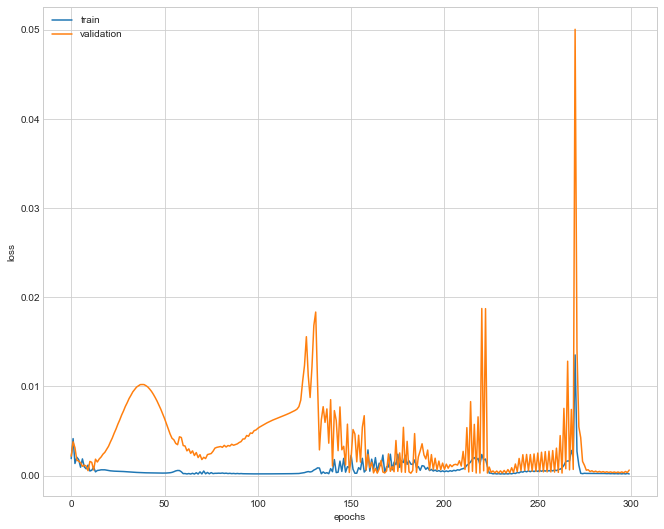

In [89]:
# Plotting training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])

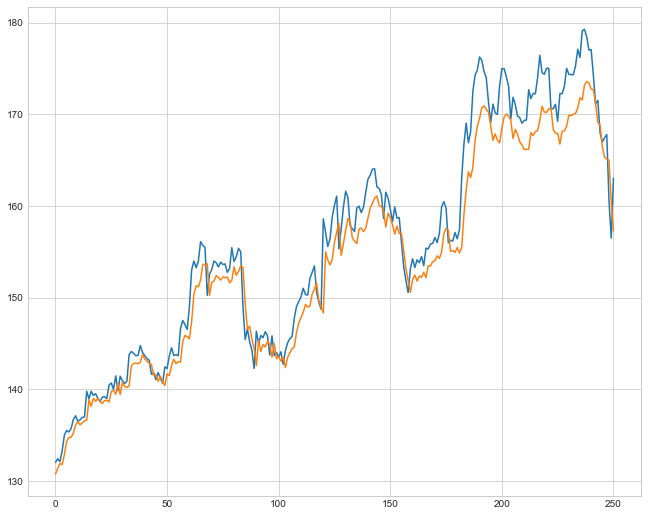

In [90]:
#Much cleaner loss this time, still could use some more data. Ideally should run multiple to get
#the average loss/val loss plots.
Xt = model.predict(X_test)
PRED = scl.inverse_transform(y_test.reshape(-1,1))
ACTUAL = scl.inverse_transform(Xt)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [91]:
print ("RMSE Value using stacked LSTM  is", np.sqrt(sum((PRED-ACTUAL)**2)/len(ACTUAL)))

RMSE Value using stacked LSTM  is [3.06635072]


RMSE value is almost as good as prophet, altough took more time for execution. Predicted values show similar trend to the actual values

# RNN

It is a class of Neural Networks wherein the connection between nodes form a directed graph along a temporal sequence which allow them to have temporal behavior. They have an advantage over feed-forward neural networks which allows them to use their internal memory to process sequence of inputs. 

In [122]:
# Importing the necessary packages and loading our time series
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

%matplotlib inline

all_stock = pd.read_csv(r'C:/Users/suraj/Project/individual_stocks_5yr/AAPL_data.csv')

all_stock.head(10)
aapl = all_stock[all_stock.Name == 'AAPL']
aapl = aapl.close.values.astype('float32')
aapl = aapl.reshape(len(aapl), 1)

aapl.shape

(1259, 1)

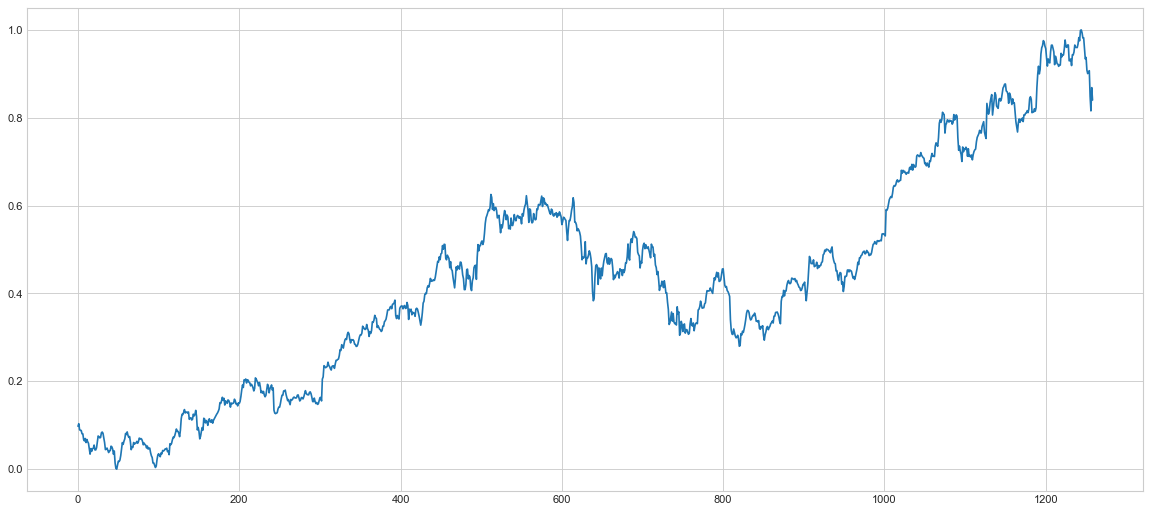

In [123]:
# Plotting our time series
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
scaler = MinMaxScaler(feature_range=(0,1))
aapl = scaler.fit_transform(aapl)
plt.plot(aapl)
plt.show()

In [124]:
# Splitting our data in train and test
train_size = int(len(aapl) * 0.80)
test_size = len(aapl) - train_size
train_set = aapl[0:train_size, :]
test_set = aapl[train_size:len(aapl), :]
print(len(train_set), len(test_set))

1007 252


In [125]:
# Preparing our train and test dataset in the array data structure
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
        
    return np.array(dataX), np.array(dataY)

In [126]:
# Applying the create_dataset function on training and testing dataset to convert them to required array data structure
look_back = 1
trainX, trainY = create_dataset(train_set, look_back)
testX, testY = create_dataset(test_set, look_back)

In [127]:
# Transformation of array to required format
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [128]:
# Transformation of array to required format
trainY = np.reshape(trainY, (trainY.shape[0], 1))
testY = np.reshape(testY, (testY.shape[0], 1))

In [129]:
testX.shape

(250, 1, 1)

Model Configuration

In [130]:
input_size = 1
num_steps = 1
lstm_size = 128 # number of LSTM hidden unit
num_layers = 2 # number of LSTM cell
max_epoch = 200

In [132]:
# Defining and applying our model
model = Sequential()
model.add(SimpleRNN(256,input_shape=(7,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

Train on 1000 samples, validate on 251 samples
Epoch 1/300
1000/1000 [==============================] - ETA: 14s - loss: 0.01 - ETA: 0s - loss: 0.0029 - 1s 656us/step - loss: 0.0024 - val_loss: 0.0031
Epoch 2/300
1000/1000 [==============================] - ETA: 0s - loss: 4.0488e-0 - ETA: 0s - loss: 5.1285e-0 - 0s 114us/step - loss: 5.6864e-04 - val_loss: 0.0012
Epoch 3/300
1000/1000 [==============================] - ETA: 0s - loss: 2.8887e-0 - ETA: 0s - loss: 3.6129e-0 - 0s 112us/step - loss: 4.2090e-04 - val_loss: 0.0027
Epoch 4/300
1000/1000 [==============================] - ETA: 0s - loss: 5.4521e-0 - ETA: 0s - loss: 9.4398e-0 - 0s 114us/step - loss: 8.0651e-04 - val_loss: 8.2442e-04
Epoch 5/300
1000/1000 [==============================] - ETA: 0s - loss: 8.6711e-0 - ETA: 0s - loss: 6.3160e-0 - 0s 111us/step - loss: 5.8895e-04 - val_loss: 0.0017
Epoch 6/300
1000/1000 [==============================] - ETA: 0s - loss: 1.6977e-0 - ETA: 0s - loss: 3.8119e-0 - 0s 110us/step - loss: 

1000/1000 [==============================] - ETA: 0s - loss: 6.7860e-0 - ETA: 0s - loss: 1.4717e-0 - 0s 99us/step - loss: 1.8285e-04 - val_loss: 5.6493e-04
Epoch 98/300
1000/1000 [==============================] - ETA: 0s - loss: 5.0157e-0 - ETA: 0s - loss: 3.4160e-0 - 0s 99us/step - loss: 3.0923e-04 - val_loss: 8.5111e-04
Epoch 99/300
1000/1000 [==============================] - ETA: 0s - loss: 7.3581e-0 - ETA: 0s - loss: 1.7577e-0 - 0s 102us/step - loss: 1.9988e-04 - val_loss: 0.0012
Epoch 100/300
1000/1000 [==============================] - ETA: 0s - loss: 4.2538e-0 - ETA: 0s - loss: 2.7764e-0 - 0s 100us/step - loss: 2.6942e-04 - val_loss: 8.7948e-04
Epoch 101/300
1000/1000 [==============================] - ETA: 0s - loss: 3.5743e-0 - ETA: 0s - loss: 2.6684e-0 - 0s 99us/step - loss: 2.6174e-04 - val_loss: 3.3674e-04
Epoch 102/300
1000/1000 [==============================] - ETA: 0s - loss: 2.6493e-0 - ETA: 0s - loss: 2.2847e-0 - 0s 100us/step - loss: 2.3601e-04 - val_loss: 4.0936e-

1000/1000 [==============================] - ETA: 0s - loss: 3.0691e-0 - ETA: 0s - loss: 2.2339e-0 - 0s 104us/step - loss: 2.2695e-04 - val_loss: 4.0654e-04
Epoch 194/300
1000/1000 [==============================] - ETA: 0s - loss: 1.2587e-0 - ETA: 0s - loss: 1.8693e-0 - 0s 100us/step - loss: 2.0888e-04 - val_loss: 5.7215e-04
Epoch 195/300
1000/1000 [==============================] - ETA: 0s - loss: 2.9064e-0 - ETA: 0s - loss: 2.5567e-0 - 0s 102us/step - loss: 2.4324e-04 - val_loss: 4.8398e-04
Epoch 196/300
1000/1000 [==============================] - ETA: 0s - loss: 1.4346e-0 - ETA: 0s - loss: 1.8376e-0 - 0s 102us/step - loss: 2.0633e-04 - val_loss: 4.5740e-04
Epoch 197/300
1000/1000 [==============================] - ETA: 0s - loss: 3.4511e-0 - ETA: 0s - loss: 2.5556e-0 - 0s 97us/step - loss: 2.3799e-04 - val_loss: 5.6064e-04
Epoch 198/300
1000/1000 [==============================] - ETA: 0s - loss: 1.4368e-0 - ETA: 0s - loss: 2.1255e-0 - 0s 101us/step - loss: 2.2790e-04 - val_loss: 

Epoch 289/300
1000/1000 [==============================] - ETA: 0s - loss: 6.8054e-0 - ETA: 0s - loss: 1.5594e-0 - 0s 106us/step - loss: 1.8498e-04 - val_loss: 3.2392e-04
Epoch 290/300
1000/1000 [==============================] - ETA: 0s - loss: 4.4167e-0 - ETA: 0s - loss: 2.3578e-0 - 0s 99us/step - loss: 2.2194e-04 - val_loss: 2.4627e-04
Epoch 291/300
1000/1000 [==============================] - ETA: 0s - loss: 6.7623e-0 - ETA: 0s - loss: 1.2595e-0 - 0s 99us/step - loss: 1.5987e-04 - val_loss: 2.4527e-04
Epoch 292/300
1000/1000 [==============================] - ETA: 0s - loss: 1.4092e-0 - ETA: 0s - loss: 1.7456e-0 - 0s 99us/step - loss: 1.9322e-04 - val_loss: 3.4798e-04
Epoch 293/300
1000/1000 [==============================] - ETA: 0s - loss: 9.1802e-0 - ETA: 0s - loss: 1.4491e-0 - 0s 98us/step - loss: 1.7524e-04 - val_loss: 2.2655e-04
Epoch 294/300
1000/1000 [==============================] - ETA: 0s - loss: 1.1404e-0 - ETA: 0s - loss: 1.5693e-0 - 0s 104us/step - loss: 1.8359e-04 -

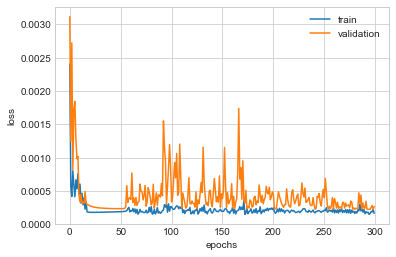

In [133]:
# Training and validation loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])

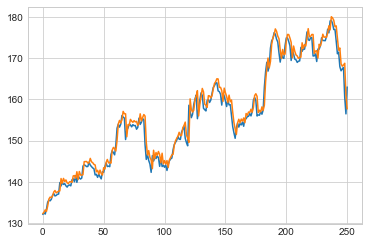

In [134]:
#We see this is pretty jumpy but we will keep it at 300 epochs. With more data, it should smooth out the loss
#Lets look at the fit
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

#This looks good for finding a trend

In [135]:
# Displaying actual and predicted values
act = []
pred = []
for i in range(251):
    Xt = model.predict(X_test[i].reshape(1,7,1))
    print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
    pred.append(scl.inverse_transform(Xt).reshape(-1,1))
    act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))
pred = scl.inverse_transform(y_test.reshape(-1,1))
actual = scl.inverse_transform(Xt)

predicted:[[132.24109]], actual:[[132.04]]
predicted:[[132.56618]], actual:[[132.42]]
predicted:[[133.1466]], actual:[[132.12]]
predicted:[[132.77232]], actual:[[133.29]]
predicted:[[134.06186]], actual:[[135.02]]
predicted:[[135.76364]], actual:[[135.51]]
predicted:[[136.24908]], actual:[[135.345]]
predicted:[[136.1112]], actual:[[135.72]]
predicted:[[136.5195]], actual:[[136.7]]
predicted:[[137.48386]], actual:[[137.11]]
predicted:[[137.85786]], actual:[[136.53]]
predicted:[[137.28607]], actual:[[136.66]]
predicted:[[137.48944]], actual:[[136.93]]
predicted:[[137.70045]], actual:[[136.99]]
predicted:[[137.76646]], actual:[[139.79]]
predicted:[[140.76947]], actual:[[138.96]]
predicted:[[139.62775]], actual:[[139.78]]
predicted:[[140.79312]], actual:[[139.34]]
predicted:[[140.04973]], actual:[[139.52]]
predicted:[[140.42729]], actual:[[139.]]
predicted:[[139.71219]], actual:[[138.68]]
predicted:[[139.54596]], actual:[[139.14]]
predicted:[[139.97607]], actual:[[139.2]]
predicted:[[140.0

In [136]:
print ("RMSE Value using RNN is", np.sqrt(sum((pred-actual)**2)/len(act)))

RMSE Value using RNN is [12.48227203]


The predicted values are much closer to the actual values. The model took lesser time than LSTM and stacked LSTM, but the RMSE value is little higher.

# Contributions

We learned a number of forecasting tecniques for time series analysis. We applied seven time series forecasting tecniques.
We took help from analytics vidya to learn AR, MA and ARMA models. The description didn't had explanation on how to perform EDA and parameters needed to apply the models. We did our own research on performing EDA.

Facebook prophet was something new and didn't had much information on how to proceed with package installation. We took help from online resources on how to install the necessary packages in anaconda environment and how to use it for forecasting. We learned how to use RNN for timeseries and how we can use SimpleRNN library for time series forecasting.

Percentage of code written by us :- 45

## Citations

* AR, MA and ARIMA:
    * https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/  <br>
    * https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ <br>
* Dickey–Fuller test:https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test <br>
* Facebook Prophet : https://www.kaggle.com/janiobachmann/s-p-500-time-series-forecasting-with-prophet
* LSTM : https://en.wikipedia.org/wiki/Long_short-term_memory
* Stacked LSTM : https://machinelearningmastery.com/stacked-long-short-term-memory-networks/ <br>
* RNN : 
    * https://www.kaggle.com/apldex/stock-prediction-using-rnn
    * https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/Time%20Series%20Prediction.ipynb
    * https://stackoverflow.com/questions/38294046/simple-recurrent-neural-network-input-shape
    * https://en.wikipedia.org/wiki/Recurrent_neural_network
* Starting reference for time series analysis : 
    * https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
    * https://towardsdatascience.com/end-to-end-time-series-analysis-and-modelling-8c34f09a3014
* Pystan installation :
    * https://pystan.readthedocs.io/en/latest/getting_started.html
    * https://wiki.python.org/moin/WindowsCompilers
* Deep learning reference and learning material :
    * https://medium.com/@margaretmz/anaconda-jupyter-notebook-tensorflow-and-keras-b91f381405f8
* Exponential smoothing :https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc433.htm <br>

# Conclusion:
As we can see, predicting stock prices is not an easy task primarily because of the insane volatile nature of the market. Infact, if everyone could predict stock prices, they probably would be really rich by now! However, that is not the case. 
In real life, stock prices requires extensive market knowledge, and surely some analytics can be helpful. That is what we have done here. 
Stock Price Time Series Forecasting is just an additonal technique for stock price prediction.
Here, we applied several algorithms, and pitted the mmagainst eachother.
The RMSE values we recorded were:
1. AR model: 14.3217
2. MA model: 14.3275
3. ARIMA: 16.78
4. Prophet: 3.23
5. LSTM: 12.42
6. Stacked LSTM: 3.066
7. RNN: 12.48

Here, AR, MA and ARIMA are some basic time series forcasting models, which gave us a good prediction. One thing tho keep in mind with Time Series is that a low RMSE value doesn't convey the complete story.
If you compare the AR, MA and ARIMA model, ARIMA shows much better variation  than AR and MA. 
Facebook's Prophet is a promising algorithm ,and expectedly performs well since it has been primarily been built for Time Series analysis.
The Neural Net trio perform really well. We feel that the models tend to overfit a bit, and further investigation is required.

### License

MIT License

Copyright (c) [2019] [Suraj Baliram Ghule] [Vedant Singhvi]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.